# Scatter RGB TO HSV

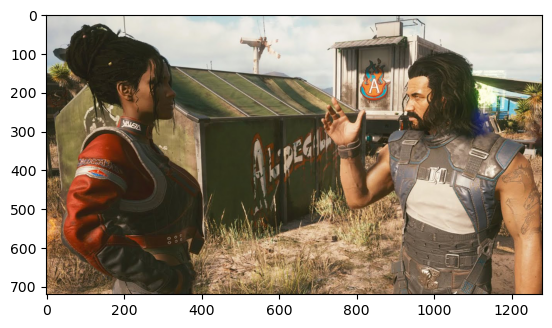

Original image shape: (720, 1280, 3)
(720, 1280, 3)


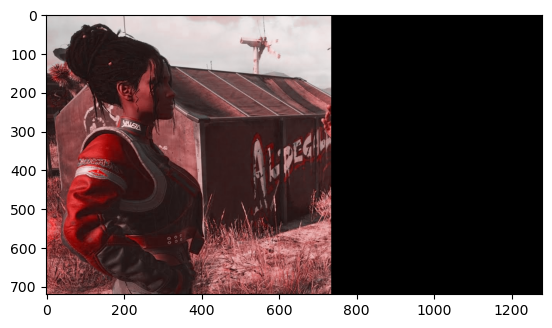

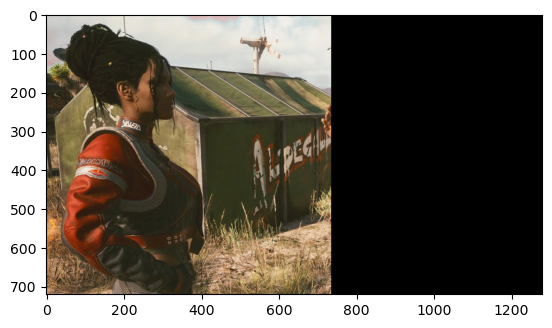

In [1]:
import numba
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2

hostInp=plt.imread("../images/maxresdefault.jpg")
plt.imshow(hostInp)
plt.show()
(H,W,C) = hostInp.shape
print("Original image shape:", hostInp.shape)



hostInp = hostInp.reshape((H, W, 3))
devInp = cuda.to_device(hostInp)


devOutHSV = cuda.device_array((H, W, 3), np.float32)  
devOutRGB = cuda.device_array((H, W, 3), np.uint8)  


hostOutHSV = np.zeros((H, W, 3), np.float32)
hostOutRGB = np.zeros((H, W, 3), np.uint8)


@cuda.jit
def RGBtoHSV(src,dst):
    x, y = cuda.grid(2)
    if y < dst.shape[0] and x < dst.shape[1]:
        r = src[y, x, 0]/255
        g = src[y, x, 1]/255
        b = src[y, x, 2]/255
        max_value = max(r, g, b)
        min_value = min(r, g, b)
        delta = max_value - min_value
        if delta == 0:
            h_value = 0
        elif max_value == r:
            h_value = 60 * (((g - b) / delta) % 6)
        elif max_value == g:
            h_value = 60 * (((b - r) / delta) + 2)
        elif max_value == src[y, x, 2]:
            h_value = 60 * (((r - g) / delta) + 4)

        if max_value == 0:
            s_value = 0
        else:
            s_value = delta / max_value
        v_value = max_value
        dst[y, x, 0] = h_value
        dst[y, x, 1] = s_value
        dst[y, x, 2] = v_value



blockSize = (32,32)
gridSizeX = (H +  blockSize[0] -1) // blockSize[0]
gridSizeY = (W +  blockSize[1] -1) // blockSize[1]

gridSize = (gridSizeX, gridSizeY)

t1 = time.time()
RGBtoHSV[gridSize, blockSize](devInp, devOutHSV)

hostOutHSV = devOutHSV.copy_to_host()
print(hostOutHSV.shape)
#print(hostOutHSV)

def hsv_to_rgb(hsv_image):
    hsv_image = hsv_image.astype(np.float32)
    hsv_image[..., 0] /= 360.0

    rgb_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    
    return rgb_image


rgb_image = hsv_to_rgb(hostOutHSV)
plt.imshow(rgb_image)
plt.show()

devInp2 = cuda.to_device(hostOutHSV)
@cuda.jit
def HSVtoRGB(src, dst):
    x, y = cuda.grid(2)

    if y < src.shape[0] and x < src.shape[1]:
        d = src[y, x, 0] / 60
        hi = int(d) % 6
        f = d - hi
        l = src[y, x, 2] * (1 - src[y, x, 1])
        m = src[y, x, 2] * (1 - f * src[y, x, 1])
        n = src[y, x, 2] * (1 - (1 - f) * src[y, x, 1])

        if 0 <= src[y, x, 0] < 60:
            r, g, b = src[y, x, 2], n, l
        elif 60 <= src[y, x, 0] < 120:
            r, g, b = m, src[y, x, 2], l
        elif 120 <= src[y, x, 0] < 180:
            r, g, b = l, src[y, x, 2], n
        elif 180 <= src[y, x, 0] < 240:
            r, g, b = l, m, src[y, x, 2]
        elif 240 <= src[y, x, 0] < 300:
            r, g, b = n, l, src[y, x, 2]
        elif 300 <= src[y, x, 0] < 360:
            r, g, b = src[y, x, 2], l, m

        dst[y, x, 0] = min(max(int(r * 255), 0), 255)
        dst[y, x, 1] = min(max(int(g * 255), 0), 255)
        dst[y, x, 2] = min(max(int(b * 255), 0), 255)



HSVtoRGB[gridSize, blockSize](devInp2, devOutRGB)
#cuda.synchronize()
hostOutRGB = devOutRGB.copy_to_host()
plt.imshow(hostOutRGB)
plt.show()

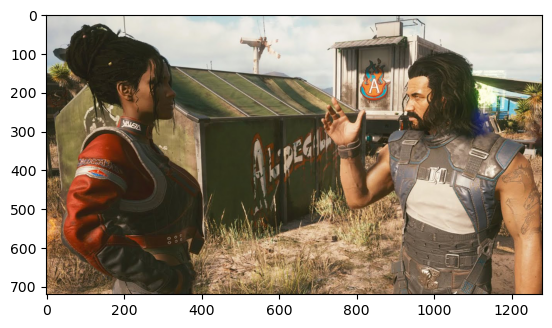

Original image shape: (720, 1280, 3)
(720, 1280, 3)


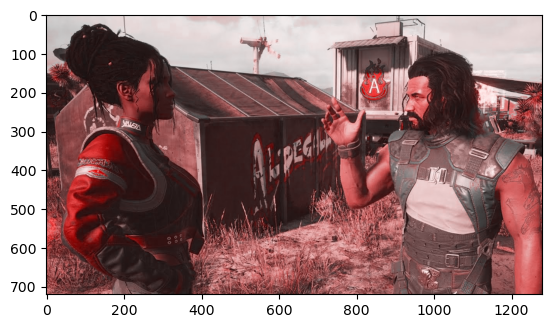

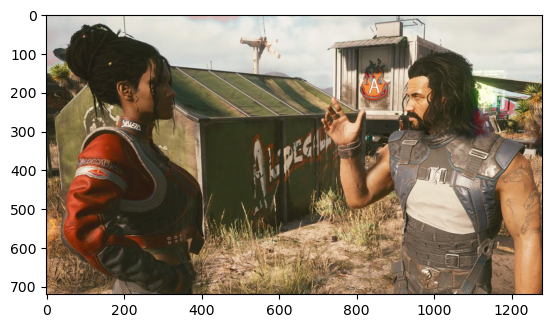

In [8]:
import numba
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2

hostInp=plt.imread("../images/maxresdefault.jpg")
plt.imshow(hostInp)
plt.show()
(H,W,C) = hostInp.shape
print("Original image shape:", hostInp.shape)



hostInp = hostInp.reshape((H * W, 3))
devInp = cuda.to_device(hostInp)


devOutHSV = cuda.device_array((H * W, 3), np.float32)  
devOutRGB = cuda.device_array((H * W, 3), np.uint8)  


hostOutHSV = np.zeros((H, W, 3), np.float32)
hostOutRGB = np.zeros((H, W, 3), np.uint8)


@cuda.jit
def RGBtoHSV(src,dst):
        x = cuda.grid(1)
        r = src[x, 0]/255
        g = src[x, 1]/255
        b = src[x, 2]/255
        max_value = max(r, g, b)
        min_value = min(r, g, b)
        delta = max_value - min_value
        if delta == 0:
            h_value = 0
        elif max_value == r:
            h_value = 60 * (((g - b) / delta) % 6)
        elif max_value == g:
            h_value = 60 * (((b - r) / delta) + 2)
        elif max_value == src[ x, 2]:
            h_value = 60 * (((r - g) / delta) + 4)

        if max_value == 0:
            s_value = 0
        else:
            s_value = delta / max_value
        v_value = max_value
        dst[x, 0] = h_value
        dst[x, 1] = s_value
        dst[x, 2] = v_value



blockSize = 64
gridSize = (H*W +  blockSize-1) // blockSize


t1 = time.time()
RGBtoHSV[gridSize, blockSize](devInp, devOutHSV)

hostOutHSV = devOutHSV.copy_to_host().reshape(H,W,C)
print(hostOutHSV.shape)
#print(hostOutHSV)

def hsv_to_rgb(hsv_image):
    hsv_image = hsv_image.astype(np.float32)
    hsv_image[..., 0] /= 360.0

    rgb_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    
    return rgb_image


rgb_image = hsv_to_rgb(hostOutHSV)
plt.imshow(rgb_image)
plt.show()

devInp2 = cuda.to_device(hostOutHSV.reshape(H*W,C))
@cuda.jit
def HSVtoRGB(src, dst):
        x= cuda.grid(1)

        d = src[x, 0] / 60
        hi = int(d) % 6
        f = d - hi
        l = src[ x, 2] * (1 - src[ x, 1])
        m = src[ x, 2] * (1 - f * src[ x, 1])
        n = src[ x, 2] * (1 - (1 - f) * src[ x, 1])

        if 0 <= src[ x, 0] < 60:
            r, g, b = src[ x, 2], n, l
        elif 60 <= src[ x, 0] < 120:
            r, g, b = m, src[ x, 2], l
        elif 120 <= src[ x, 0] < 180:
            r, g, b = l, src[ x, 2], n
        elif 180 <= src[ x, 0] < 240:
            r, g, b = l, m, src[ x, 2]
        elif 240 <= src[ x, 0] < 300:
            r, g, b = n, l, src[ x, 2]
        elif 300 <= src[ x, 0] < 360:
            r, g, b = src[ x, 2], l, m

        dst[ x, 0] = min(max(int(r * 255), 0), 255)
        dst[ x, 1] = min(max(int(g * 255), 0), 255)
        dst[ x, 2] = min(max(int(b * 255), 0), 255)



HSVtoRGB[gridSize, blockSize](devInp2, devOutRGB)
#cuda.synchronize()
hostOutRGB = devOutRGB.copy_to_host().reshape(H,W,C)
plt.imshow(hostOutRGB)
plt.show()